[MON] corr(pred, A_obs) calib=0.259 | corr(pred, A_star) calib=0.626


UnboundLocalError: local variable 'r2' referenced before assignment

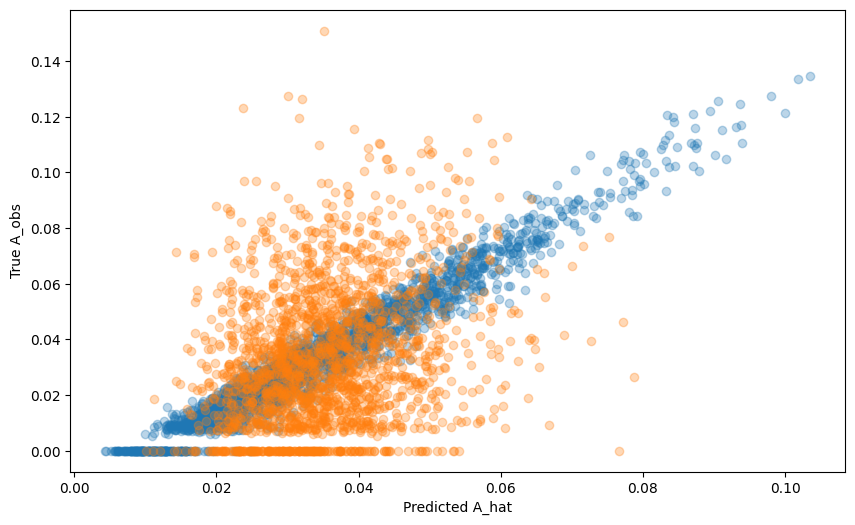

In [ ]:
# =========================
# Clean, doc-level pipeline
# =========================

from __future__ import annotations

import math, random, os
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Sequence, Optional
from collections import Counter

import numpy as np
from numpy.random import default_rng

from scipy.sparse import csr_matrix
from scipy.optimize import linear_sum_assignment

from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import Ridge, LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, accuracy_score

import pandas as pd


#### load arguments
import argparse

SEED = 42
name_exp = "test"
n_train = 100
n_calib = 100
temp = 1.5
delta = 0.5
epsilon = 0.5


# ---- local modules you already split out ----
from config import (
    SynthConfig, Document, Candidate,
    make_topics, generate_corpus, softmax_temp, dirichlet_sample
)
from unit import (
    BaseUnit, Unit, assemble_augmented_docs_and_units, gen_candidates_for_mask,
    build_units, assemble_feature_label_arrays_doclevel
)
from helper_similarity_metrics import (
    cosine_from_counts, cosine_from_freq, counts_vec, distinct_1, js_divergence
)
from cp_selection import (
    per_doc_S_doclevel, per_doc_S_doclevel_multi, global_threshold_S_doclevel,
    fit_conditional_threshold_doclevel
)
from featurize_document import featurize_candidate_doclevel, compute_idf


def set_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)


# ------------------------------
# Scores & features (doc-level)
# ------------------------------

def predict_for_units_doclevel(units: List[Unit],
                               reg: Any,
                               idf: np.ndarray,
                               phi: np.ndarray,
                               target: str = "obs",
                               oracle_mode: str = "cosine",
                               as_log: bool = False) -> None:
    """
    Compute features (also sets A_obs_doc / A_star_doc) and write A_hat back to each Unit.
    """
    X, _, _ = assemble_feature_label_arrays_doclevel(
        units, idf, phi, target=target, oracle_mode=oracle_mode, as_log=as_log
    )
    if X.shape[0] == 0:
        return
    yhat = reg.predict(X).astype(np.float32)
    for u, yh in zip(units, yhat):
        u.A_hat = float(yh)


# ------------------------------
# Eval helper: infer θ from tokens (given φ) and doc-level metrics
# ------------------------------

def expected_theta_from_tokens(tokens: List[int],
                               phi: np.ndarray,
                               prior: np.ndarray | None = None) -> np.ndarray:
    """
    Approximate doc topic mixture from tokens given known phi.
    p(k|w) ∝ phi[k,w]*prior[k]; accumulate over tokens.
    """
    K, V = phi.shape
    if prior is None:
        prior = np.ones(K, dtype=np.float64) / K
    prior = prior / prior.sum()

    counts = np.zeros(K, dtype=np.float64)
    for w in tokens:
        pw = phi[:, w] + 1e-20
        post = pw * prior
        s = post.sum()
        if s > 0:
            counts += post / s
    if counts.sum() == 0.0:
        return prior.copy()
    return counts / counts.sum()


def apply_filter_and_eval_doclevel(units_by_doc: Dict[int, List[Unit]],
                                   s_global: float,
                                   lambda_obs: float,
                                   rho: int,
                                   phi: np.ndarray) -> Dict[str, Any]:
    """
    Filter with A_hat >= s_global at the doc level and evaluate:
      - miscoverage: P(accept & A_obs_doc < lambda_obs)
      - accept_rate: accepted docs / total docs
      - distinct_1: diversity over accepted replacements
      - jsd_drift: JSD(θ_true, θ_aug) using φ as oracle to infer θ_aug from tokens
    """
    n_docs = len(units_by_doc)
    miscover_cnt = 0
    accepted_total = 0
    all_accepted_tokens: List[int] = []
    jsd_vals: List[float] = []

    for _, units in units_by_doc.items():
        u = units[0]
        accepted = bool(u.A_hat >= s_global)
        if accepted:
            accepted_total += 1
            if u.A_obs_doc < lambda_obs:
                miscover_cnt += 1

            # diversity
            for sent in u.candidates:
                all_accepted_tokens.extend(sent)

            # drift
            aug_tokens = [t for s in (u.doc_ctx + u.candidates) for t in s]
            orig_theta = u.doc_theta / (u.doc_theta.sum() + 1e-20)
            aug_theta  = expected_theta_from_tokens(aug_tokens, phi, prior=orig_theta)
            jsd_vals.append(js_divergence(orig_theta, aug_theta))

    return {
        "miscoverage": miscover_cnt / max(1, n_docs),
        "accept_rate": accepted_total / max(1, n_docs),
        "distinct_1": distinct_1(all_accepted_tokens),
        "jsd_drift": float(np.mean(jsd_vals)) if jsd_vals else 0.0,
    }


# ------------------------------
# LDA + downstream tasks
# ------------------------------

def flatten_doc(sentences: List[List[int]]) -> List[int]:
    return [tok for s in sentences for tok in s]

def tokens_to_dtm(docs_tokens: List[List[int]], V: int) -> csr_matrix:
    """CSR doc-term matrix from list of token-id lists."""
    indptr, indices, data = [0], [], []
    for toks in docs_tokens:
        cnt = Counter(toks)
        if cnt:
            k, v = zip(*cnt.items())
            indices.extend(k)
            data.extend(v)
        indptr.append(len(indices))
    return csr_matrix((np.asarray(data, dtype=np.int64),
                       np.asarray(indices, dtype=np.int32),
                       np.asarray(indptr, dtype=np.int32)),
                      shape=(len(docs_tokens), V), dtype=np.float32)

def unit_to_aug_tokens(u: Unit) -> List[int]:
    toks: List[int] = []
    for s in u.doc_ctx: toks.extend(s)
    for s in u.candidates: toks.extend(s)
    return toks


# --- helpers for "full-corpus" LDA evaluation ---

def original_tokens_for(docs, idxs=None):
    if idxs is None:
        idxs = range(len(docs))
    return [flatten_doc(docs[i].sentences) for i in idxs]

def units_to_aug_docs(units: List[Unit]) -> List[List[int]]:
    # Each Unit is treated as its own doc for the augmented corpus
    return [unit_to_aug_tokens(u) for u in units]

def fit_lda_and_transform_many(X_train: csr_matrix,
                               X_list_to_transform: List[csr_matrix],
                               K: int, alpha: float, beta: float, seed: int):
    """
    Fit an LDA on X_train, then .transform() every matrix in X_list_to_transform.
    Returns (lda, phi_hat, [W_0, W_1, ...]) where W_i = transform(X_list_to_transform[i]).
    """
    lda = LatentDirichletAllocation(
        n_components=K,
        doc_topic_prior=alpha,
        topic_word_prior=beta,
        learning_method="batch",
        max_iter=100,
        random_state=seed,
        evaluate_every=0,
    )
    _ = lda.fit_transform(X_train)
    comps = lda.components_.astype(np.float64) + 1e-12
    phi_hat = comps / comps.sum(axis=1, keepdims=True)
    W_list = [lda.transform(X) for X in X_list_to_transform]
    return lda, phi_hat, W_list

def align_topics(phi_true: np.ndarray, phi_hat: np.ndarray) -> Tuple[np.ndarray, float, float]:
    """Align phi_hat to phi_true via Hungarian on JSD; return (perm, mean_jsd, mean_cos)."""
    K = phi_true.shape[0]
    D = np.zeros((K, K), dtype=np.float64)
    C = np.zeros((K, K), dtype=np.float64)
    for i in range(K):
        pi = phi_true[i] / (phi_true[i].sum() + 1e-12)
        for j in range(K):
            pj = phi_hat[j] / (phi_hat[j].sum() + 1e-12)
            m = 0.5*(pi + pj)
            def _kl(a,b):
                mask = a > 0
                return float((a[mask] * (np.log(a[mask]/(b[mask]+1e-20) + 1e-20))).sum())
            js = 0.5*_kl(pi, m) + 0.5*_kl(pj, m)
            D[i,j] = js / np.log(2.0)
            C[i,j] = float(np.dot(pi, pj) / (np.linalg.norm(pi)*np.linalg.norm(pj) + 1e-20))
    r, c = linear_sum_assignment(D)
    return c, float(D[r, c].mean()), float(C[r, c].mean())

def _align_and_doc_theta_metrics(phi_true: np.ndarray,
                                 phi_hat: np.ndarray,
                                 W_docs: np.ndarray,  # shape (n_docs, K) from lda.transform
                                 Theta_true: np.ndarray) -> Tuple[Dict[str, float], np.ndarray, np.ndarray]:
    """
    Align phi_hat to phi_true; reorder W_docs columns; compute topic + doc-theta metrics.
    """
    perm, mean_jsd, mean_cos = align_topics(phi_true, phi_hat)
    phi_hat_aligned = phi_hat[perm]
    W_aligned = W_docs[:, perm]
    l1 = float(np.mean(np.linalg.norm(W_aligned - Theta_true, ord=1, axis=1)))
    l2 = float(np.mean(np.linalg.norm(W_aligned - Theta_true, ord=2, axis=1)))
    return {
        "phi_mean_jsd": float(mean_jsd),
        "phi_mean_cos": float(mean_cos),
        "theta_l1_mean": l1,
        "theta_l2_mean": l2,
    }, phi_hat_aligned, W_aligned


# ------------------------------
# Selection metrics + optional full-corpus LDA comparison
# ------------------------------


import numpy as np
from typing import List, Tuple, Dict, Any, Sequence, Optional
from scipy.sparse import csr_matrix

# ---------- Lexical helpers ----------
def _corpus_ngram_set(token_lists: List[List[int]], n: int = 1) -> set:
    S = set()
    if n == 1:
        for doc in token_lists:
            S.update(doc)
    else:
        for doc in token_lists:
            if len(doc) >= n:
                S.update(tuple(doc[i:i+n]) for i in range(len(doc)-n+1))
    return S

def _distinct_n(token_lists: List[List[int]], n: int = 1) -> float:
    total = sum(max(0, len(doc)-n+1) if n > 1 else len(doc) for doc in token_lists)
    if total == 0:
        return 0.0
    S = _corpus_ngram_set(token_lists, n=n)
    return len(S) / float(total)

def _lexical_diversity_metrics(orig_tokens: List[List[int]],
                               aug_tokens:  List[List[int]]) -> Dict[str, float]:
    # distinct-n
    d1_o = _distinct_n(orig_tokens, n=1)
    d2_o = _distinct_n(orig_tokens, n=2)
    d1_a = _distinct_n(orig_tokens + aug_tokens, n=1)
    d2_a = _distinct_n(orig_tokens + aug_tokens, n=2)

    # type coverage and Jaccard
    Uo1 = _corpus_ngram_set(orig_tokens, n=1)
    Ua1 = _corpus_ngram_set(orig_tokens + aug_tokens, n=1)
    Uo2 = _corpus_ngram_set(orig_tokens, n=2)
    Ua2 = _corpus_ngram_set(orig_tokens + aug_tokens, n=2)

    new_vocab_frac = 0.0 if len(Ua1) == 0 else len(Ua1 - Uo1) / float(len(Ua1))
    jacc1 = 0.0 if (len(Uo1|Ua1) == 0) else len(Uo1 & Ua1) / float(len(Uo1 | Ua1))
    jacc2 = 0.0 if (len(Uo2|Ua2) == 0) else len(Uo2 & Ua2) / float(len(Uo2 | Ua2))

    return {
        "distinct1_unaug": d1_o, "distinct2_unaug": d2_o,
        "distinct1_with_aug": d1_a, "distinct2_with_aug": d2_a,
        "new_vocab_frac": new_vocab_frac,
        "jaccard_unigram": jacc1, "jaccard_bigram": jacc2,
    }

# ---------- Document-space helpers (tf/random projection) ----------
def _row_l2_normalize_dense(X: np.ndarray) -> np.ndarray:
    norms = np.linalg.norm(X, axis=1, keepdims=True) + 1e-12
    return X / norms

def _effective_num_points_from_dense_unit_rows(Z: np.ndarray, block: int = 2048) -> float:
    """
    Z: (n,d) with each row L2-normalized. Computes ENP = n^2 / sum_{ij} (cos_ij)^2
    in blocks to keep memory manageable.
    """
    n = Z.shape[0]
    if n == 0:
        return 0.0
    fro2 = 0.0
    for i in range(0, n, block):
        Gi = Z[i:i+block] @ Z.T         # (b, n)
        fro2 += float(np.sum(Gi * Gi))  # squared Frobenius
    return (n * n) / max(fro2, 1e-12)

def _dup_rate_from_dense_unit_rows(Z: np.ndarray, tau: float = 0.95, block: int = 2048) -> float:
    """
    Fraction of rows whose maximum cosine similarity to any other row >= tau.
    """
    n = Z.shape[0]
    if n <= 1:
        return 0.0
    hits = 0
    for i in range(0, n, block):
        b = min(block, n - i)
        Gi = Z[i:i+b] @ Z.T  # (b, n)
        # suppress self-similarity on the block diagonal
        for r, j in enumerate(range(i, i+b)):
            Gi[r, j] = -1.0
        hits += int(np.sum(np.max(Gi, axis=1) >= tau))
    return hits / float(n)

def _random_projection_enp_and_dups(X_csr: csr_matrix,
                                    rp_dim: int = 256,
                                    seed: int = 0,
                                    tau_dup: float = 0.95,
                                    block: int = 2048) -> Tuple[float, float]:
    """
    Projects csr TF matrix to low-dim dense space, L2-normalizes rows,
    returns (ENP, dup_rate).
    """
    n, V = X_csr.shape
    if n == 0:
        return 0.0, 0.0
    rng = np.random.default_rng(seed)
    R = rng.normal(0.0, 1.0 / np.sqrt(rp_dim), size=(V, rp_dim))  # Gaussian RP
    # TF (not TF-IDF): normalize rows to unit L2 first to make cosine meaningful
    # Compute row norms for TF
    row_norms = np.sqrt(X_csr.multiply(X_csr).sum(axis=1)).A1 + 1e-12
    Xn = X_csr.multiply(1.0 / row_norms[:, None])                  # csr
    Z = Xn @ R                                                     # dense (n, rp_dim)
    Z = _row_l2_normalize_dense(Z)
    enp = _effective_num_points_from_dense_unit_rows(Z, block=block)
    dup = _dup_rate_from_dense_unit_rows(Z, tau=tau_dup, block=block)
    return enp, dup

# ---------- Topic-space helpers ----------
def _effective_num_points_topic(W: np.ndarray, block: int = 8192) -> float:
    """
    ENP in topic space. W may be any nonnegative doc-topic weights.
    We L2-normalize rows and apply the same participation ratio.
    """
    if W.size == 0:
        return 0.0
    Z = _row_l2_normalize_dense(W)
    return _effective_num_points_from_dense_unit_rows(Z, block=block)

def _dup_rate_topic(W: np.ndarray, tau: float = 0.95, block: int = 8192) -> float:
    if W.size == 0:
        return 0.0
    Z = _row_l2_normalize_dense(W)
    return _dup_rate_from_dense_unit_rows(Z, tau=tau, block=block)



def evaluate_selected_doclevel(selected_by_doc: Dict[int, List[Unit]],
                               doc_total_units: Dict[int, int],
                               phi: np.ndarray,
                               lambda_obs: float,
                               rho: int,
                               *,
                               full_corpus_lda: bool = True,
                               docs: Optional[List[Document]] = None,
                               splits: Optional[Dict[str, np.ndarray]] = None,
                               extra_selected_units: Optional[List[Unit]] = None,
                               seed: int = 0) -> Dict[str, Any]:
    """
    (A) Original selection metrics (unchanged): miscoverage, accept_rate, diversity, doc-level drift.
    (B) OPTIONAL (full_corpus_lda=True): re-fit LDA on the entire corpus and compare topic/theta recovery
        - 'unaug_full' : LDA on original TRAIN+CALIB+TEST docs
        - 'aug_full'   : LDA on (unaug_full + selected augmented docs)

    Pass `extra_selected_units` to include accepted units from TRAIN/CALIB as well.
    """
    # ---------- (A) selection metrics ----------
    n_docs = len(doc_total_units)
    if n_docs == 0:
        base = {"miscoverage": 0.0, "accept_rate": 0.0, "distinct_1": 0.0,
                "jsd_drift": 0.0, "l1_drift": 0.0, "l2_drift": 0.0,
                "l1_drift_topic": 0.0, "l2_drift_topic": 0.0}
    else:
        miscover_cnt, accepted_total, total_units = 0, 0, 0
        all_accepted_tokens: List[int] = []
        jsd_vals: List[float] = []
        l1_vals: List[float] = []
        l2_vals: List[float] = []

        for doc_idx, tot in doc_total_units.items():
            accepted = selected_by_doc.get(doc_idx, [])
            accepted_total += len(accepted)
            total_units += int(tot)
            bad_accepts = sum(1 for u in accepted if float(u.A_obs_doc) < float(lambda_obs))
            if bad_accepts > rho:
                miscover_cnt += 1
            if accepted:
                for u in accepted:
                    for sent in u.candidates:
                        all_accepted_tokens.extend(sent)

                u0 = accepted[0]
                orig_theta = u0.doc_theta / (u0.doc_theta.sum() + 1e-20)
                aug_tokens = [t for s in u0.doc_ctx for t in s]
                for u in accepted:
                    for s in u.candidates:
                        aug_tokens.extend(s)
                aug_theta = expected_theta_from_tokens(aug_tokens, phi, prior=orig_theta)
                jsd_vals.append(js_divergence(orig_theta, aug_theta))
                l2_vals.append(np.linalg.norm(orig_theta - aug_theta, ord=2))
                l1_vals.append(np.linalg.norm(orig_theta - aug_theta, ord=1))

        base = {
            "miscoverage": miscover_cnt / max(1, n_docs),
            "accept_rate": accepted_total / max(1, total_units),
            "distinct_1": distinct_1(all_accepted_tokens),
            "jsd_drift": float(np.mean(jsd_vals)) if jsd_vals else 0.0,
            "l1_drift": float(np.mean(l1_vals)) if l1_vals else 0.0,
            "l2_drift": float(np.mean(l2_vals)) if l2_vals else 0.0,
            "l1_drift_topic": 0.0,   # filled only when full_corpus_lda=True
            "l2_drift_topic": 0.0,
        }

    if not full_corpus_lda:
        return base

    # ---------- (B) re-fit LDA on FULL CORPUS (with/without augmentation) ----------
    assert docs is not None and splits is not None, \
        "When full_corpus_lda=True, pass docs= and splits={'idx_train','idx_calib','idx_aug'}."

    V = phi.shape[1]
    idx_all = np.r_[splits["idx_train"], splits["idx_calib"], splits["idx_aug"]]

    # Unaugmented full corpus = all original docs
    orig_all_tokens = original_tokens_for(docs, idx_all)
    X_all_orig = tokens_to_dtm(orig_all_tokens, V)

    # Augmented docs = accepted units from selected_by_doc (+ optionally extra_selected_units)
    accepted_eval_units = [u for lst in selected_by_doc.values() for u in lst]
    extra = extra_selected_units or []
    aug_tokens = units_to_aug_docs(accepted_eval_units + extra)

    # Build train corpora for LDA
    X_unaug_train = tokens_to_dtm(orig_all_tokens, V)
    X_aug_train   = tokens_to_dtm(orig_all_tokens + aug_tokens, V)

    # Fit LDA on unaugmented full corpus; transform original docs
    lda_u, phi_u, [W_all_u] = fit_lda_and_transform_many(
        X_train=X_unaug_train,
        X_list_to_transform=[X_all_orig],
        K=phi.shape[0], alpha=1.0/phi.shape[0], beta=1.0/V, seed=seed
    )

    Theta_all_true = np.vstack([docs[i].theta for i in idx_all])
    metrics_u, phi_u_aligned, W_all_u_aligned = _align_and_doc_theta_metrics(
        phi_true=phi, phi_hat=phi_u, W_docs=W_all_u, Theta_true=Theta_all_true
    )

    # Fit LDA on augmented full corpus; transform original docs
    lda_a, phi_a, [W_all_a] = fit_lda_and_transform_many(
        X_train=X_aug_train,
        X_list_to_transform=[X_all_orig],
        K=phi.shape[0], alpha=1.0/phi.shape[0], beta=1.0/V, seed=seed
    )
    metrics_a, phi_a_aligned, W_all_a_aligned = _align_and_doc_theta_metrics(
        phi_true=phi, phi_hat=phi_a, W_docs=W_all_a, Theta_true=Theta_all_true
    )

    # Topic drift (phi vs phi_hat) as mean per-topic norms
    metrics_u["l1_drift_topic"] = float(np.mean(np.linalg.norm(phi - phi_u_aligned, ord=1, axis=1)))
    metrics_u["l2_drift_topic"] = float(np.mean(np.linalg.norm(phi - phi_u_aligned, ord=2, axis=1)))
    metrics_a["l1_drift_topic"] = float(np.mean(np.linalg.norm(phi - phi_a_aligned, ord=1, axis=1)))
    metrics_a["l2_drift_topic"] = float(np.mean(np.linalg.norm(phi - phi_a_aligned, ord=2, axis=1)))

    ##### Need to measure the diversity of the augmented docs

        # ---------- Diversity of (unaug) vs (with aug) corpora ----------
    # 1) Lexical metrics (distinct-n, new types, Jaccard)
    lex_metrics = _lexical_diversity_metrics(orig_all_tokens, aug_tokens)

    # 2) Document-space (TF) ENP and near-duplicate rate via random projection
    #    (use the *same* random seed so the comparison is fair)
    ENP_unaug_tf, dup_unaug_tf = _random_projection_enp_and_dups(
        X_unaug_train, rp_dim=256, seed=seed, tau_dup=0.95, block=2048
    )
    ENP_with_aug_tf, dup_with_aug_tf = _random_projection_enp_and_dups(
        X_aug_train, rp_dim=256, seed=seed, tau_dup=0.95, block=2048
    )

    # 3) Topic-space ENP / near-duplicate rate
    #    (a) on originals under the unaug LDA (already aligned): W_all_u_aligned
    ENP_unaug_topic = _effective_num_points_topic(W_all_u_aligned, block=8192)
    dup_unaug_topic = _dup_rate_topic(W_all_u_aligned, tau=0.95, block=8192)

    #    (b) on originals+augmented docs under the aug LDA
    #        - transform augmented docs and align columns using perm_a
    X_aug_docs_only = tokens_to_dtm(aug_tokens, phi.shape[1])
    W_aug_docs = lda_a.transform(X_aug_docs_only)  # (n_aug_docs, K)
    # We already computed 'perm_a' above when aligning phi_a; reuse it:
    perm_a, _, _ = align_topics(phi, phi_a)
    W_aug_docs_aligned = W_aug_docs[:, perm_a]

    W_full_with_aug = np.vstack([W_all_a_aligned, W_aug_docs_aligned])
    ENP_with_aug_topic = _effective_num_points_topic(W_full_with_aug, block=8192)
    dup_with_aug_topic = _dup_rate_topic(W_full_with_aug, tau=0.95, block=8192)

    # Attach to metrics dicts
    diversity_block = {
        # lexical
        **lex_metrics,
        # TF doc-space
        "enp_tf_unaug": ENP_unaug_tf,
        "enp_tf_with_aug": ENP_with_aug_tf,
        "dup_rate_tf_unaug": dup_unaug_tf,
        "dup_rate_tf_with_aug": dup_with_aug_tf,
        # topic doc-space
        "enp_topic_unaug": ENP_unaug_topic,
        "enp_topic_with_aug": ENP_with_aug_topic,
        "dup_rate_topic_unaug": dup_unaug_topic,
        "dup_rate_topic_with_aug": dup_with_aug_topic,
    }

    # You can keep them as a separate subtree or merge:
    metrics_u.update({
        "enp_tf": ENP_unaug_tf,
        "dup_rate_tf": dup_unaug_tf,
        "enp_topic": ENP_unaug_topic,
        "dup_rate_topic": dup_unaug_topic,
        # propagate lexical baselines on the unaug side for convenience
        "distinct1": lex_metrics["distinct1_unaug"],
        "distinct2": lex_metrics["distinct2_unaug"],
    })

    metrics_a.update({
        "enp_tf": ENP_with_aug_tf,
        "dup_rate_tf": dup_with_aug_tf,
        "enp_topic": ENP_with_aug_topic,
        "dup_rate_topic": dup_with_aug_topic,
        "distinct1": lex_metrics["distinct1_with_aug"],
        "distinct2": lex_metrics["distinct2_with_aug"],
        "new_vocab_frac": lex_metrics["new_vocab_frac"],
        "jaccard_unigram": lex_metrics["jaccard_unigram"],
        "jaccard_bigram": lex_metrics["jaccard_bigram"],
    })

    # If your function returns a combined dict, include the diversity info:
    return {
        **base,
        "lda_full": {
            "unaug_full": metrics_u,
            "aug_full":   metrics_a,
            "diversity":  diversity_block,  # optional: consolidated view
        }
    }


# ------------------------------
# Full-corpus LDA + downstream on unseen set
# ------------------------------

def evaluate_lda_and_downstream(cfg: SynthConfig,
                                res: Dict[str, Any],
                                seed: int = 0,
                                n_unseen_eval_docs: int = 1000,
                                include_train_aug: bool = False,
                                include_calib_aug: bool = False
                                ) -> Tuple[Dict[str, Any], Dict[str, Dict[str, float]]]:
    """
    LDA on FULL corpora (TRAIN+CALIB+TEST) with four variants and
    downstream evaluation on a NEW unseen synthetic set.

    Buckets:
      - 'unaug_full'          : originals only
      - 'aug_full_cp'         : originals + CP-selected eval augmentations
      - 'aug_full_unfiltered' : originals + all eval augmentations
      - 'aug_full_obs'        : originals + eval augmentations with A_obs >= lambda

    Optional flags can include CP-selected TRAIN/CALIB augmentations in 'aug_full_cp'.
    """
    import pandas as pd
    from sklearn.linear_model import LinearRegression, LogisticRegression

    rng = np.random.default_rng(seed + 202)

    phi_true   = res["phi"]
    docs       = res["docs"]
    aug_units  = res["aug_units"]
    idx_train  = np.asarray(res["splits"]["idx_train"])
    idx_calib  = np.asarray(res["splits"]["idx_calib"])
    idx_aug    = np.asarray(res["splits"]["idx_aug"])
    idx_all    = np.r_[idx_train, idx_calib, idx_aug]
    V          = phi_true.shape[1]

    # ---------- originals (train+calib+test) ----------
    orig_all_tokens = [flatten_doc(docs[i].sentences) for i in idx_all]
    X_all_orig = tokens_to_dtm(orig_all_tokens, V)
    X_unaug_train = X_all_orig  # train matrix for 'unaug_full'

    # ---------- augmentation pools (EVAL only by default) ----------
    # Ensure eval units have A_obs/A_hat already (run_synthetic_experiment should have done this)
    eval_units_all = [u for u in aug_units if u.doc_idx in set(idx_aug)]
    eval_units_obs = [u for u in eval_units_all if not np.isnan(u.A_obs_doc) and u.A_obs_doc >= float(cfg.lambda_obs)]
    # Marginal-CP-selected eval units saved by run_synthetic_experiment
    sel_by_doc_eval_marg = res.get("marginal_cp", {}).get("selected_by_doc", {})
    eval_units_marg = [u for lst in sel_by_doc_eval_marg.values() for u in lst]



    # CP-selected eval units come from the saved selection
    sel_by_doc_eval = res["conditional"]["selected_by_doc"]
    eval_units_cp = [u for lst in sel_by_doc_eval.values() for u in lst]

    # Optionally add TRAIN/CALIB CP-selected units to the CP bucket
    extra_cp_units: List[Unit] = []
    if include_train_aug or include_calib_aug:
        # we may need predictions for train/calib if not already present
        train_units_all = [u for u in aug_units if u.doc_idx in set(idx_train)]
        calib_units_all = [u for u in aug_units if u.doc_idx in set(idx_calib)]
        if any(np.isnan(getattr(u, "A_hat", np.nan)) or np.isnan(getattr(u, "A_obs_doc", np.nan))
               for u in (train_units_all + calib_units_all)):
            predict_for_units_doclevel(train_units_all + calib_units_all,
                                       res["reg"], res["idf"], res["phi"], target="obs")

        if include_train_aug:
            cc_train = fit_conditional_threshold_doclevel(
                calib_units=calib_units_all, test_units=train_units_all,
                idf=res["idf"], phi=res["phi"],
                lambda_obs=cfg.lambda_obs, alpha_cp=cfg.alpha_cp, rho=cfg.rho, verbose=False
            )
            _, _, sel_by_doc_train, sel_train_units = cc_train
            extra_cp_units.extend(sel_train_units)

        if include_calib_aug:
            cc_calib = fit_conditional_threshold_doclevel(
                calib_units=calib_units_all, test_units=calib_units_all,
                idf=res["idf"], phi=res["phi"],
                lambda_obs=cfg.lambda_obs, alpha_cp=cfg.alpha_cp, rho=cfg.rho, verbose=False
            )
            _, _, sel_by_doc_calib, sel_calib_units = cc_calib
            extra_cp_units.extend(sel_calib_units)

    # ---------- training corpora for each bucket ----------
    def units_to_docs(units: List[Unit]) -> List[List[int]]:
        return [unit_to_aug_tokens(u) for u in units]

    corpora_train = {
        "unaug_full":          orig_all_tokens,
        "aug_full_cp":         orig_all_tokens + units_to_docs(eval_units_cp + extra_cp_units),
        "aug_full_unfiltered": orig_all_tokens + units_to_docs(eval_units_all),
        "aug_full_obs":        orig_all_tokens + units_to_docs(eval_units_obs),
        "aug_full_marginal":   orig_all_tokens + units_to_docs(eval_units_marg),  # NEW
    }

    X_train_by_bucket = {k: tokens_to_dtm(v, V) for k, v in corpora_train.items()}

    # ---------- new unseen set ----------
    cfg_unseen = SynthConfig(
        V=cfg.V, K=cfg.K, beta=cfg.beta, alpha=cfg.alpha,
        n_docs=n_unseen_eval_docs, S=cfg.S, L=cfg.L,
        mask_frac=cfg.mask_frac, Kgen=cfg.Kgen,
        delta=cfg.delta, epsilon=cfg.epsilon, T=cfg.T,
        lambda_obs=cfg.lambda_obs, rho=cfg.rho, alpha_cp=cfg.alpha_cp,
        n_train_docs=0, n_calib_docs=0, n_aug_docs=0, seed=seed + 777
    )
    unseen_docs = generate_corpus(cfg_unseen, phi_true, rng)
    X_unseen_orig = tokens_to_dtm([flatten_doc(d.sentences) for d in unseen_docs], V)

    Theta_all_true = np.vstack([docs[i].theta for i in idx_all])
    Theta_unseen   = np.vstack([d.theta for d in unseen_docs])

    # ---------- fit one LDA per bucket; compute topic/theta recovery ----------
    lda_results: Dict[str, Dict[str, float]] = {}
    W_all_aligned_by_bucket: Dict[str, np.ndarray]   = {}
    W_unseen_aligned_by_bucket: Dict[str, np.ndarray] = {}

    for bucket, Xtr in X_train_by_bucket.items():
        lda, phi_hat, [W_all, W_unseen] = fit_lda_and_transform_many(
            X_train=Xtr,
            X_list_to_transform=[X_all_orig, X_unseen_orig],
            K=cfg.K, alpha=cfg.alpha, beta=cfg.beta, seed=seed
        )
        # metrics on ALL original docs
        met, phi_hat_aligned, W_all_aligned = _align_and_doc_theta_metrics(
            phi_true=phi_true, phi_hat=phi_hat, W_docs=W_all, Theta_true=Theta_all_true
        )
        # align unseen too
        perm, _, _ = align_topics(phi_true, phi_hat)
        W_unseen_aligned = W_unseen[:, perm]

        # topic drift norms (mean across topics)
        met["l1_drift_topic"] = float(np.mean(np.linalg.norm(phi_true - phi_hat_aligned, ord=1, axis=1)))
        met["l2_drift_topic"] = float(np.mean(np.linalg.norm(phi_true - phi_hat_aligned, ord=2, axis=1)))

        lda_results[bucket] = met
        W_all_aligned_by_bucket[bucket]   = W_all_aligned
        W_unseen_aligned_by_bucket[bucket] = W_unseen_aligned

    # ---------- downstream on unseen; models trained on ALL originals ----------
    results_runs = []
    for rep in range(10):
        beta_reg = rng.normal(0, 1, size=cfg.K)
        beta_clf = rng.normal(0, 1, size=cfg.K)
        def sigmoid(x): return 1.0 / (1.0 + np.exp(-x))

        # outcomes from true thetas
        y_reg_all    = Theta_all_true @ beta_reg + rng.normal(0, 0.1, size=Theta_all_true.shape[0])
        y_reg_unseen = Theta_unseen   @ beta_reg + rng.normal(0, 0.1, size=Theta_unseen.shape[0])

        logit_all    = Theta_all_true @ beta_clf + rng.normal(0, 0.5, size=Theta_all_true.shape[0])
        logit_unseen = Theta_unseen   @ beta_clf + rng.normal(0, 0.5, size=Theta_unseen.shape[0])
        y_clf_all    = (sigmoid(logit_all)    > 0.5).astype(int)
        y_clf_unseen = (sigmoid(logit_unseen) > 0.5).astype(int)

        for bucket in ["unaug_full", "aug_full_cp", "aug_full_unfiltered", "aug_full_obs", "aug_full_marginal"]:
            W_all    = W_all_aligned_by_bucket[bucket]
            W_unseen = W_unseen_aligned_by_bucket[bucket]

            # OLS regression
            ols = LinearRegression()
            ols.fit(W_all, y_reg_all)
            y_pred = ols.predict(W_unseen)
            mse = mean_squared_error(y_reg_unseen, y_pred)
            r2  = r2_score(y_reg_unseen, y_pred)

            # Logistic classification
            clf = LogisticRegression(max_iter=1000, random_state=seed)
            clf.fit(W_all, y_clf_all)
            y_prob = clf.predict_proba(W_unseen)[:, 1]
            y_hat  = (y_prob >= 0.5).astype(int)
            auc = roc_auc_score(y_clf_unseen, y_prob)
            acc = accuracy_score(y_clf_unseen, y_hat)

            results_runs.append({
                "bucket": bucket,
                "reg_mse": float(mse), "reg_r2": float(r2),
                "clf_auc": float(auc), "clf_acc": float(acc),
            })

    df = pd.DataFrame(results_runs)
    downstream_metrics = df.groupby("bucket", sort=False).mean(numeric_only=True).to_dict(orient="index")
    return lda_results, downstream_metrics

# ------------------------------
# Result packaging
# ------------------------------
def results_to_row(cfg: SynthConfig,
                   res: Dict[str, Any],
                   lda_results: Dict[str, Any],
                   downstream_metrics: Dict[str, Dict[str, float]]) -> Dict[str, Any]:
    # --- config & selection metrics (unchanged) ---
    row = {
        "V": cfg.V, "K": cfg.K, "beta": cfg.beta, "alpha": cfg.alpha,
        "n_docs": cfg.n_docs, "S": cfg.S, "L": cfg.L, "mask_frac": cfg.mask_frac,
        "Kgen": cfg.Kgen, "delta": cfg.delta, "epsilon": cfg.epsilon, "T": cfg.T,
        "lambda_obs": cfg.lambda_obs, "rho": cfg.rho, "alpha_cp": cfg.alpha_cp,
        "n_train_docs": cfg.n_train_docs, "n_calib_docs": cfg.n_calib_docs, "n_aug_docs": cfg.n_aug_docs,
        "seed": cfg.seed,

        # CP selection metrics
        "CP_miscoverage": res["conditional"]["metrics"]["miscoverage"],
        "CP_accept_rate": res["conditional"]["metrics"]["accept_rate"],
        "CP_distinct_1":  res["conditional"]["metrics"]["distinct_1"],
        "CP_jsd_drift":   res["conditional"]["metrics"]["jsd_drift"],  # renamed for consistency

        # Baseline selection metrics
        "base_unf_miscoverage": res["baselines"]["unfiltered"]["miscoverage"],
        "base_unf_accept_rate": res["baselines"]["unfiltered"]["accept_rate"],
        "base_obs_miscoverage": res["baselines"]["observed_filter"]["miscoverage"],
        "base_obs_accept_rate": res["baselines"]["observed_filter"]["accept_rate"],
        
    }
    row.update({
    "Marg_miscoverage": res.get("marginal_cp", {}).get("metrics", {}).get("miscoverage", np.nan),
    "Marg_accept_rate": res.get("marginal_cp", {}).get("metrics", {}).get("accept_rate", np.nan),
    "Marg_distinct_1":  res.get("marginal_cp", {}).get("metrics", {}).get("distinct_1", np.nan),
    "Marg_jsd_drift":   res.get("marginal_cp", {}).get("metrics", {}).get("jsd_drift", np.nan),
   })
    

    # --- full-corpus LDA / downstream buckets ---
    # Canonical names we want to report:
    desired_buckets = [
        ("unaug_full",          "unaug_full"),
        ("aug_full_cp",         "aug_full_cp"),          # CP-selected augmentations
        ("aug_full_unfiltered", "aug_full_unfiltered"),  # ALL augmentations
        ("aug_full_obs",        "aug_full_obs"),         # L_obs-filtered augmentations
         ("aug_full_marginal",   "aug_full_marginal"),      # Marginal CP-selected augmentations
    ]
    # Backward-compat: if caller only produced "aug_full", treat it as CP-selected
    if ("aug_full_cp" not in lda_results and "aug_full_cp" not in downstream_metrics
        and ("aug_full" in lda_results or "aug_full" in downstream_metrics)):
        lda_results.setdefault("aug_full_cp", lda_results.get("aug_full", {}))
        downstream_metrics.setdefault("aug_full_cp", downstream_metrics.get("aug_full", {}))

    for key, tag in desired_buckets:
        # topic/theta recovery (if present)
        if key in lda_results:
            lr = lda_results[key]
            if "phi_mean_jsd" in lr: row[f"topic_jsd_{tag}"] = float(lr["phi_mean_jsd"])
            if "phi_mean_cos" in lr: row[f"topic_cos_{tag}"] = float(lr["phi_mean_cos"])
            if "theta_l1_mean" in lr: row[f"theta_l1_{tag}"] = float(lr["theta_l1_mean"])
            if "theta_l2_mean" in lr: row[f"theta_l2_{tag}"] = float(lr["theta_l2_mean"])
            if "l1_drift_topic" in lr: row[f"phi_l1_{tag}"] = float(lr["l1_drift_topic"])
            if "l2_drift_topic" in lr: row[f"phi_l2_{tag}"] = float(lr["l2_drift_topic"])
            # If you added corpus diversity metrics there, record them too:
            for extra in ("div_entropy", "div_effN", "div_type_token", "dup_rate"):
                if extra in lr:
                    row[f"{extra}_{tag}"] = float(lr[extra])

        # downstream (if present)
        if key in downstream_metrics:
            dm = downstream_metrics[key]
            # keys depend on whether you used OLS or Ridge; both expose mse/r2
            if "reg_mse" in dm: row[f"reg_mse_{tag}"] = float(dm["reg_mse"])
            if "reg_r2"  in dm: row[f"reg_r2_{tag}"]  = float(dm["reg_r2"])
            if "clf_auc" in dm: row[f"clf_auc_{tag}"] = float(dm["clf_auc"])
            if "clf_acc" in dm: row[f"clf_acc_{tag}"] = float(dm["clf_acc"])

    return row



# ------------------------------
# Orchestration
# ------------------------------

def run_synthetic_experiment(cfg: SynthConfig,
                             target_for_reg: str = "observed",
                             verbose: bool = True) -> Dict[str, Any]:
    """
    Full pipeline:
      1) Sample topics phi and corpus (theta, z, sentences)
      2) Build base units with Kgen candidates per masked sent (doc-level)
      3) Build Kgen augmented doc Units per original doc
      4) Train A_hat regressor on TRAIN augmented docs
      5) Calibrate conditional thresholds on CALIB; select on EVAL
      6) Evaluate selection metrics; return artifacts
    """
    set_seed(cfg.seed)
    rng = default_rng(cfg.seed)

    # 1) topics & corpus
    phi  = make_topics(cfg, rng)
    docs = generate_corpus(cfg, phi, rng)

    # 2) split by doc index
    idx_all   = np.arange(cfg.n_docs)
    idx_train = idx_all[:cfg.n_train_docs]
    idx_calib = idx_all[cfg.n_train_docs: cfg.n_train_docs + cfg.n_calib_docs]
    idx_aug   = idx_all[cfg.n_train_docs + cfg.n_calib_docs:
                        cfg.n_train_docs + cfg.n_calib_docs + cfg.n_aug_docs]

    # 3) build base units and augmented units
    base_units, base_by_doc, all_sents = build_units(cfg, docs, phi, rng)
    aug_units, aug_docs = assemble_augmented_docs_and_units(docs, base_by_doc, cfg.Kgen)

    # 4) IDF
    idf = compute_idf(all_sents, cfg.V)

    # 5) Train regressor on TRAIN augmented docs
    train_units = [u for u in aug_units if u.doc_idx in set(idx_train)]
    X_train, y_train, _ = assemble_feature_label_arrays_doclevel(
        train_units, idf, phi, target=target_for_reg, oracle_mode="cosine", as_log=False
    )

    _, y_train_oracle, _ = assemble_feature_label_arrays_doclevel(
        train_units, idf, phi, target="oracle", oracle_mode="cosine", as_log=False
    )

    reg = RandomForestRegressor(n_estimators=300, max_depth=None, random_state=cfg.seed, n_jobs=-1)
    reg.fit(X_train, y_train)



    # Compute correlations on calib (for monitoring)
    calib_units = [u for u in aug_units if u.doc_idx in set(idx_calib)]
    X_calib, y_calib, _ = assemble_feature_label_arrays_doclevel(
        calib_units, idf, phi, target="observed", oracle_mode="cosine", as_log=False
    )
    _, y_calib_oracle, _ = assemble_feature_label_arrays_doclevel(
        calib_units, idf, phi, target="oracle", oracle_mode="cosine", as_log=False
    )
    corr_calib_ahat   = float(np.corrcoef(reg.predict(X_calib), y_calib)[0, 1])
    corr_calib_oracle = float(np.corrcoef(reg.predict(X_calib), y_calib_oracle)[0, 1])
    if verbose:
        print(f"[MON] corr(pred, A_obs) calib={corr_calib_ahat:.3f} | corr(pred, A_star) calib={corr_calib_oracle:.3f}")

        #### Make nice plot
    r2 = np.corrcoef(reg.predict(X_calib), y_calib)[0, 1]
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.scatter(reg.predict(X_train), y_train, alpha=0.3, label='Train Predictions')
    plt.scatter(reg.predict(X_calib), y_calib, alpha=0.3, label='Calib Predictions')
    plt.xlabel('Predicted A_hat')
    plt.ylabel('True A_obs')
    plt.title('Predicted vs True A_obs: correlation on calib = {:.3f}'.format(r2))
    plt.legend()
    plt.grid(True)
    plt.show()


    
    ### Make nice plot
    r2 = np.corrcoef(reg.predict(X_calib), corr_calib_oracle)[0, 1]
    plt.figure(figsize=(10, 6))
    plt.scatter(reg.predict(X_train), y_train_oracle, alpha=0.3, label='Train Predictions')
    plt.scatter(reg.predict(X_calib), corr_calib_oracle, alpha=0.3, label='Calib Predictions')
    plt.xlabel('Predicted A_hat')
    plt.ylabel('Oracle A_star')
    plt.title('Predicted vs Oracle A_star: correlation on calib = {:.3f}'.format(r2))
    plt.legend()
    plt.grid(True)
    plt.show()

    # Predict A_hat for TRAIN/CALIB/EVAL
    eval_units  = [u for u in aug_units if u.doc_idx in set(idx_aug)]
    predict_for_units_doclevel(train_units, reg, idf, phi, target="obs")
    predict_for_units_doclevel(calib_units, reg, idf, phi, target="obs")
    predict_for_units_doclevel(eval_units,  reg, idf, phi, target="obs")

    # 6) Conditional thresholds (fit on calib, apply to eval)
    if verbose:
        print(f"Training on {len(train_units)} augmented docs; calibrating on {len(calib_units)}; evaluating on {len(eval_units)}.")

    cc_model, thresholds_by_doc, selected_by_doc, selected_units = fit_conditional_threshold_doclevel(
        calib_units=calib_units,
        test_units=eval_units,
        idf=idf,
        phi=phi,
        lambda_obs=cfg.lambda_obs,
        alpha_cp=cfg.alpha_cp,
        rho=cfg.rho,
        verbose=True,
    )

    # Per-doc denominators for accept-rate on eval
    doc_total_eval: Dict[int, int] = {}
    for u in eval_units:
        doc_total_eval[u.doc_idx] = doc_total_eval.get(u.doc_idx, 0) + 1

    # Selection metrics; optionally include full-corpus LDA comparison (eval acceptances only here)
    cc_metrics = evaluate_selected_doclevel(
        selected_by_doc,
        doc_total_eval,
        phi,
        lambda_obs=cfg.lambda_obs,
        rho=cfg.rho,
        full_corpus_lda=True,                      # compare unaug vs (unaug + eval-accepts)
        docs=docs,
        splits={"idx_train": idx_train, "idx_calib": idx_calib, "idx_aug": idx_aug},
        seed=cfg.seed
    )

    # Baselines on eval
    selected_unfiltered_by_doc: Dict[int, List[Unit]] = {}
    for u in eval_units:
        selected_unfiltered_by_doc.setdefault(u.doc_idx, []).append(u)

    baseline_unfiltered = evaluate_selected_doclevel(
        selected_unfiltered_by_doc,
        doc_total_eval,
        phi,
        cfg.lambda_obs,
        cfg.rho,
        full_corpus_lda=True,
        docs=docs,
        splits={"idx_train": idx_train, "idx_calib": idx_calib, "idx_aug": idx_aug},
        seed=cfg.seed,
    )


    selected_observed_by_doc: Dict[int, List[Unit]] = {}
    for u in eval_units:
        if float(u.A_obs_doc) >= float(cfg.lambda_obs):
            selected_observed_by_doc.setdefault(u.doc_idx, []).append(u)

    baseline_observed = evaluate_selected_doclevel(
        selected_observed_by_doc,
        doc_total_eval,
        phi,
        cfg.lambda_obs,
        cfg.rho,
        full_corpus_lda=True,
        docs=docs,
        splits={"idx_train": idx_train, "idx_calib": idx_calib, "idx_aug": idx_aug},
        seed=cfg.seed,
    )

    try:
        s_global_marginal = global_threshold_S_doclevel(
            calib_units,
            lambda_obs=cfg.lambda_obs,
            alpha_cp=cfg.alpha_cp,
            rho=cfg.rho,          # keep if your helper supports doc-level rho; otherwise remove
        )
    except TypeError:
        # fallback if your helper doesn't take rho
        s_global_marginal = global_threshold_S_doclevel(
            calib_units,
            lambda_obs=cfg.lambda_obs,
            alpha_cp=cfg.alpha_cp,
        )

    selected_marginal_by_doc: Dict[int, List[Unit]] = {}
    for u in eval_units:  # only select on the eval set
        if float(u.A_hat) >= float(s_global_marginal):
            selected_marginal_by_doc.setdefault(u.doc_idx, []).append(u)

    marginal_metrics = evaluate_selected_doclevel(
        selected_marginal_by_doc,
        doc_total_eval,
        phi,
        lambda_obs=cfg.lambda_obs,
        rho=cfg.rho,
        full_corpus_lda=True,   # keep this False to avoid passing docs/splits here
    )

    # Pretty print
    n_sel = sum(len(v) for v in selected_by_doc.values())
    n_tot = sum(doc_total_eval.values())
    if verbose:
        print(f"[CC] Selected generations: {n_sel} / {n_tot} ({100.0 * n_sel / max(1, n_tot):.1f}%)")
        print(f"[CC] Metrics (conditional): {cc_metrics}")
        print(f"[BASE] Unfiltered: {baseline_unfiltered}")
        print(f"[BASE] Observed  : {baseline_observed}")

    # Package results
    results = {
        "config": cfg,
        "splits": {"idx_train": idx_train, "idx_calib": idx_calib, "idx_aug": idx_aug},
        "phi": phi,
        "docs": docs,
        "idf": idf,
        "reg": reg,
        "aug_units": aug_units,
        "train_units": train_units,
        "calib_units": calib_units,
        "eval_units": eval_units,
        "conditional": {
            "model": cc_model,
            "thresholds_by_doc": thresholds_by_doc,
            "selected_by_doc": selected_by_doc,
            "selected_units": selected_units,
            "metrics": cc_metrics,
        },
         "marginal_cp": {
        "threshold": float(s_global_marginal),
        "selected_by_doc": selected_marginal_by_doc,
        "metrics": marginal_metrics,
       },
        "baselines": {
            "unfiltered": baseline_unfiltered,
            "observed_filter": baseline_observed,
        }
    }
    return results


# =========================
# Example run
# =========================
if __name__ == "__main__":
    os.makedirs("results", exist_ok=True)
    results_df = pd.DataFrame()

    for alpha_cp in [0.05, 0.1, 0.2]:
        cfg = SynthConfig(
            V=1000, K=3, beta=0.1, alpha=0.3,
            n_docs=n_train + n_calib + 500, S=10, L=12, mask_frac=0.5, Kgen=20,
            delta=delta, epsilon=epsilon, T=temp,
            lambda_obs=0.01, rho=10, alpha_cp=alpha_cp,
            n_train_docs=n_train, n_calib_docs=n_calib, n_aug_docs=500,
            seed=SEED
        )
        for lambda_obs in [0.05, 0.1, 0.25, 0.35]:
            for rho in [0, 1, 2, 5, 10]:
                cfg.rho = rho
                cfg.alpha_cp = alpha_cp
                cfg.lambda_obs = lambda_obs

                res = run_synthetic_experiment(cfg)
                print(f"Config: {cfg}, Results: {res['conditional']['metrics']}")

                # Full-corpus LDA + downstream on unseen set
                lda_results, downstream_metrics = evaluate_lda_and_downstream(cfg, res, seed=cfg.seed)

                row = results_to_row(cfg, res, lda_results, downstream_metrics)
                results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)
                out_path = os.path.join("results", f"synthetic_results_llm_cp_{name_exp}.csv")
                results_df.to_csv(out_path, index=False)

                print(results_df.tail(1))  # last row just added
                print("Done")
